In [3]:
pip install --user theano

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

# Load the CSV file to examine its structure
file_path = 'csv/samples_big_no_phi_delta11_01.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the format
data.head(), data.shape


(      beta0  beta_LUT  beta_Humid  beta_TEMP     alpha   rho_int   rho_slo  \
 0 -7.585284 -0.004805   -0.062381   0.215918 -0.421799  0.023170  0.089909   
 1 -7.557590 -0.004750   -0.062472   0.215217 -0.408405  0.054201  0.092967   
 2 -7.624084 -0.004874   -0.062252   0.217089 -0.412970  0.013741  0.046707   
 3 -7.624899 -0.004867   -0.062213   0.216993 -0.415976  0.018263  0.050146   
 4 -7.624998 -0.004801   -0.062194   0.216891 -0.410475  0.008631  0.111790   
 
     tau_int   tau_slo  
 0  1.103298  1.179314  
 1  1.183658  1.062173  
 2  1.073465  1.060308  
 3  1.052011  1.047350  
 4  1.123130  1.152574  ,
 (4000, 9))

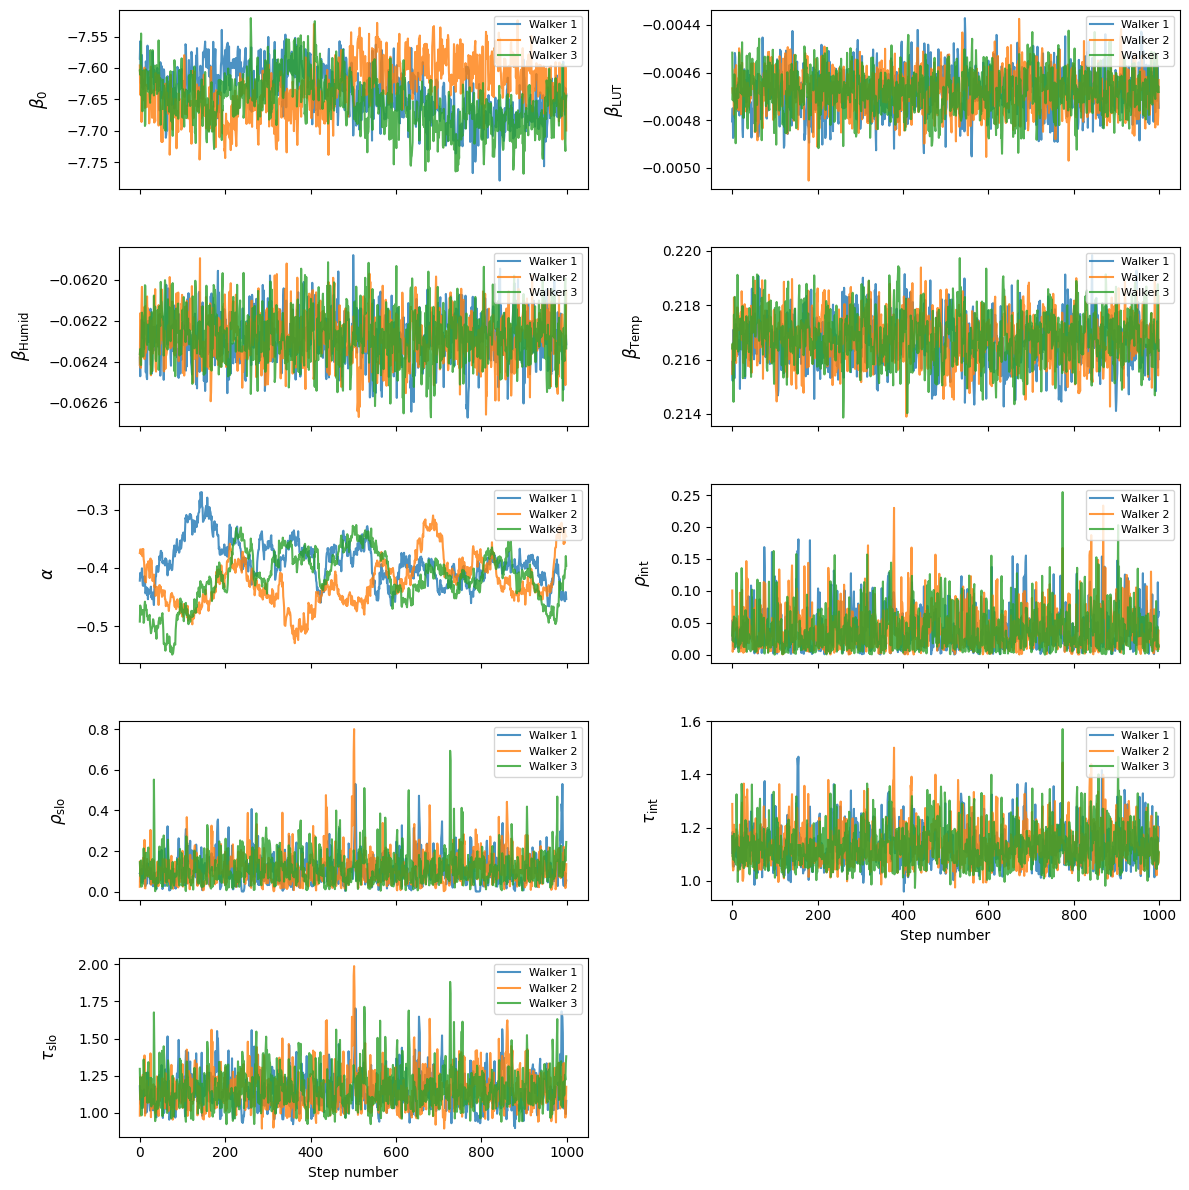

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract samples and split by walkers
num_walkers = 3
samples_per_walker = 1000

# Splitting data for each walker
walkers = [
    data.iloc[i * samples_per_walker : (i + 1) * samples_per_walker].reset_index(drop=True)
    for i in range(num_walkers)
]

# Labels for the plots
labels = [
    r"$\beta_0$", r"$\beta_{\text{LUT}}$", r"$\beta_{\text{Humid}}$", r"$\beta_{\text{Temp}}$",
    r"$\alpha$", r"$\rho_{\text{int}}$", r"$\rho_{\text{slo}}$",
    r"$\tau_{\text{int}}$", r"$\tau_{\text{slo}}$"
]

# Create plots
fig, axes = plt.subplots(5, 2, figsize=(12, 12), sharex=True)
axes = axes.flatten()

# Parameter names corresponding to column names
param_names = ['beta0', 'beta_LUT', 'beta_Humid', 'beta_TEMP', 'alpha', 
               'rho_int', 'rho_slo', 'tau_int', 'tau_slo']

# Plotting each parameter
for idx, ax in enumerate(axes):
    if idx < len(param_names):
        param = param_names[idx]
        for i, walker_data in enumerate(walkers):
            ax.plot(walker_data[param], label=f'Walker {i + 1}', alpha=0.8)
        ax.set_ylabel(labels[idx], rotation=90, labelpad=20, fontsize=12, va='center')
        ax.legend(fontsize=8, loc='upper right')
    else:
        ax.axis('off')  # Hide unused axes

# Shared x-label for bottom plots
axes[-3].tick_params(axis='x', which='both', bottom=True, labelbottom=True)
axes[-3].set_xlabel("Step number")
axes[-2].set_xlabel("Step number")

plt.tight_layout()
fig.savefig("img/sampling_big.png", format="png")
plt.show()


In [7]:
import numpy as np
import pandas as pd

# Load the data
file_path = 'csv/samples_big_no_phi_delta11_01.csv'
data = pd.read_csv(file_path)

# Remove the last walker (last 1000 samples)
data_trimmed = data.iloc[:-1000]

# Define a function to calculate the mean and 95% confidence interval
def calculate_statistics(samples):
    mean = np.mean(samples)
    lower, upper = np.percentile(samples, [2.5, 97.5])  # 95% confidence interval
    return mean, (lower, upper)

# Iterate over each parameter and calculate statistics
results = {}
for column in data_trimmed.columns:
    mean, conf_interval = calculate_statistics(data_trimmed[column])
    results[column] = {"mean": mean, "95% CI": conf_interval}

# Print the results
for param, stats in results.items():
    print(f"{param}: Mean = {stats['mean']:.4f}, 95% CI = [{stats['95% CI'][0]:.4f}, {stats['95% CI'][1]:.4f}]")


beta0: Mean = -7.6412, 95% CI = [-7.7224, -7.5607]
beta_LUT: Mean = -0.0047, 95% CI = [-0.0049, -0.0045]
beta_Humid: Mean = -0.0623, 95% CI = [-0.0625, -0.0620]
beta_TEMP: Mean = 0.2168, 95% CI = [0.2150, 0.2186]
alpha: Mean = -0.4099, 95% CI = [-0.4997, -0.3254]
rho_int: Mean = 0.0396, 95% CI = [0.0014, 0.1228]
rho_slo: Mean = 0.1134, 95% CI = [0.0114, 0.3066]
tau_int: Mean = 1.1337, 95% CI = [1.0193, 1.3190]
tau_slo: Mean = 1.1558, 95% CI = [0.9631, 1.4552]


In [8]:
# Calculate mean and 95% confidence intervals for tau_int^2 and tau_slo^2
def calculate_squared_statistics(samples):
    squared_samples = samples ** 2  # Square the samples
    mean = np.mean(squared_samples)
    lower, upper = np.percentile(squared_samples, [2.5, 97.5])  # 95% confidence interval
    return mean, (lower, upper)

# Extract columns for tau_int and tau_slo, and calculate statistics for their squares
tau_int_squared_stats = calculate_squared_statistics(data_trimmed["tau_int"])
tau_slo_squared_stats = calculate_squared_statistics(data_trimmed["tau_slo"])

# Print the results
print(f"tau_int^2: Mean = {tau_int_squared_stats[0]:.4f}, 95% CI = [{tau_int_squared_stats[1][0]:.4f}, {tau_int_squared_stats[1][1]:.4f}]")
print(f"tau_slo^2: Mean = {tau_slo_squared_stats[0]:.4f}, 95% CI = [{tau_slo_squared_stats[1][0]:.4f}, {tau_slo_squared_stats[1][1]:.4f}]")


tau_int^2: Mean = 1.2912, 95% CI = [1.0389, 1.7398]
tau_slo^2: Mean = 1.3525, 95% CI = [0.9275, 2.1176]


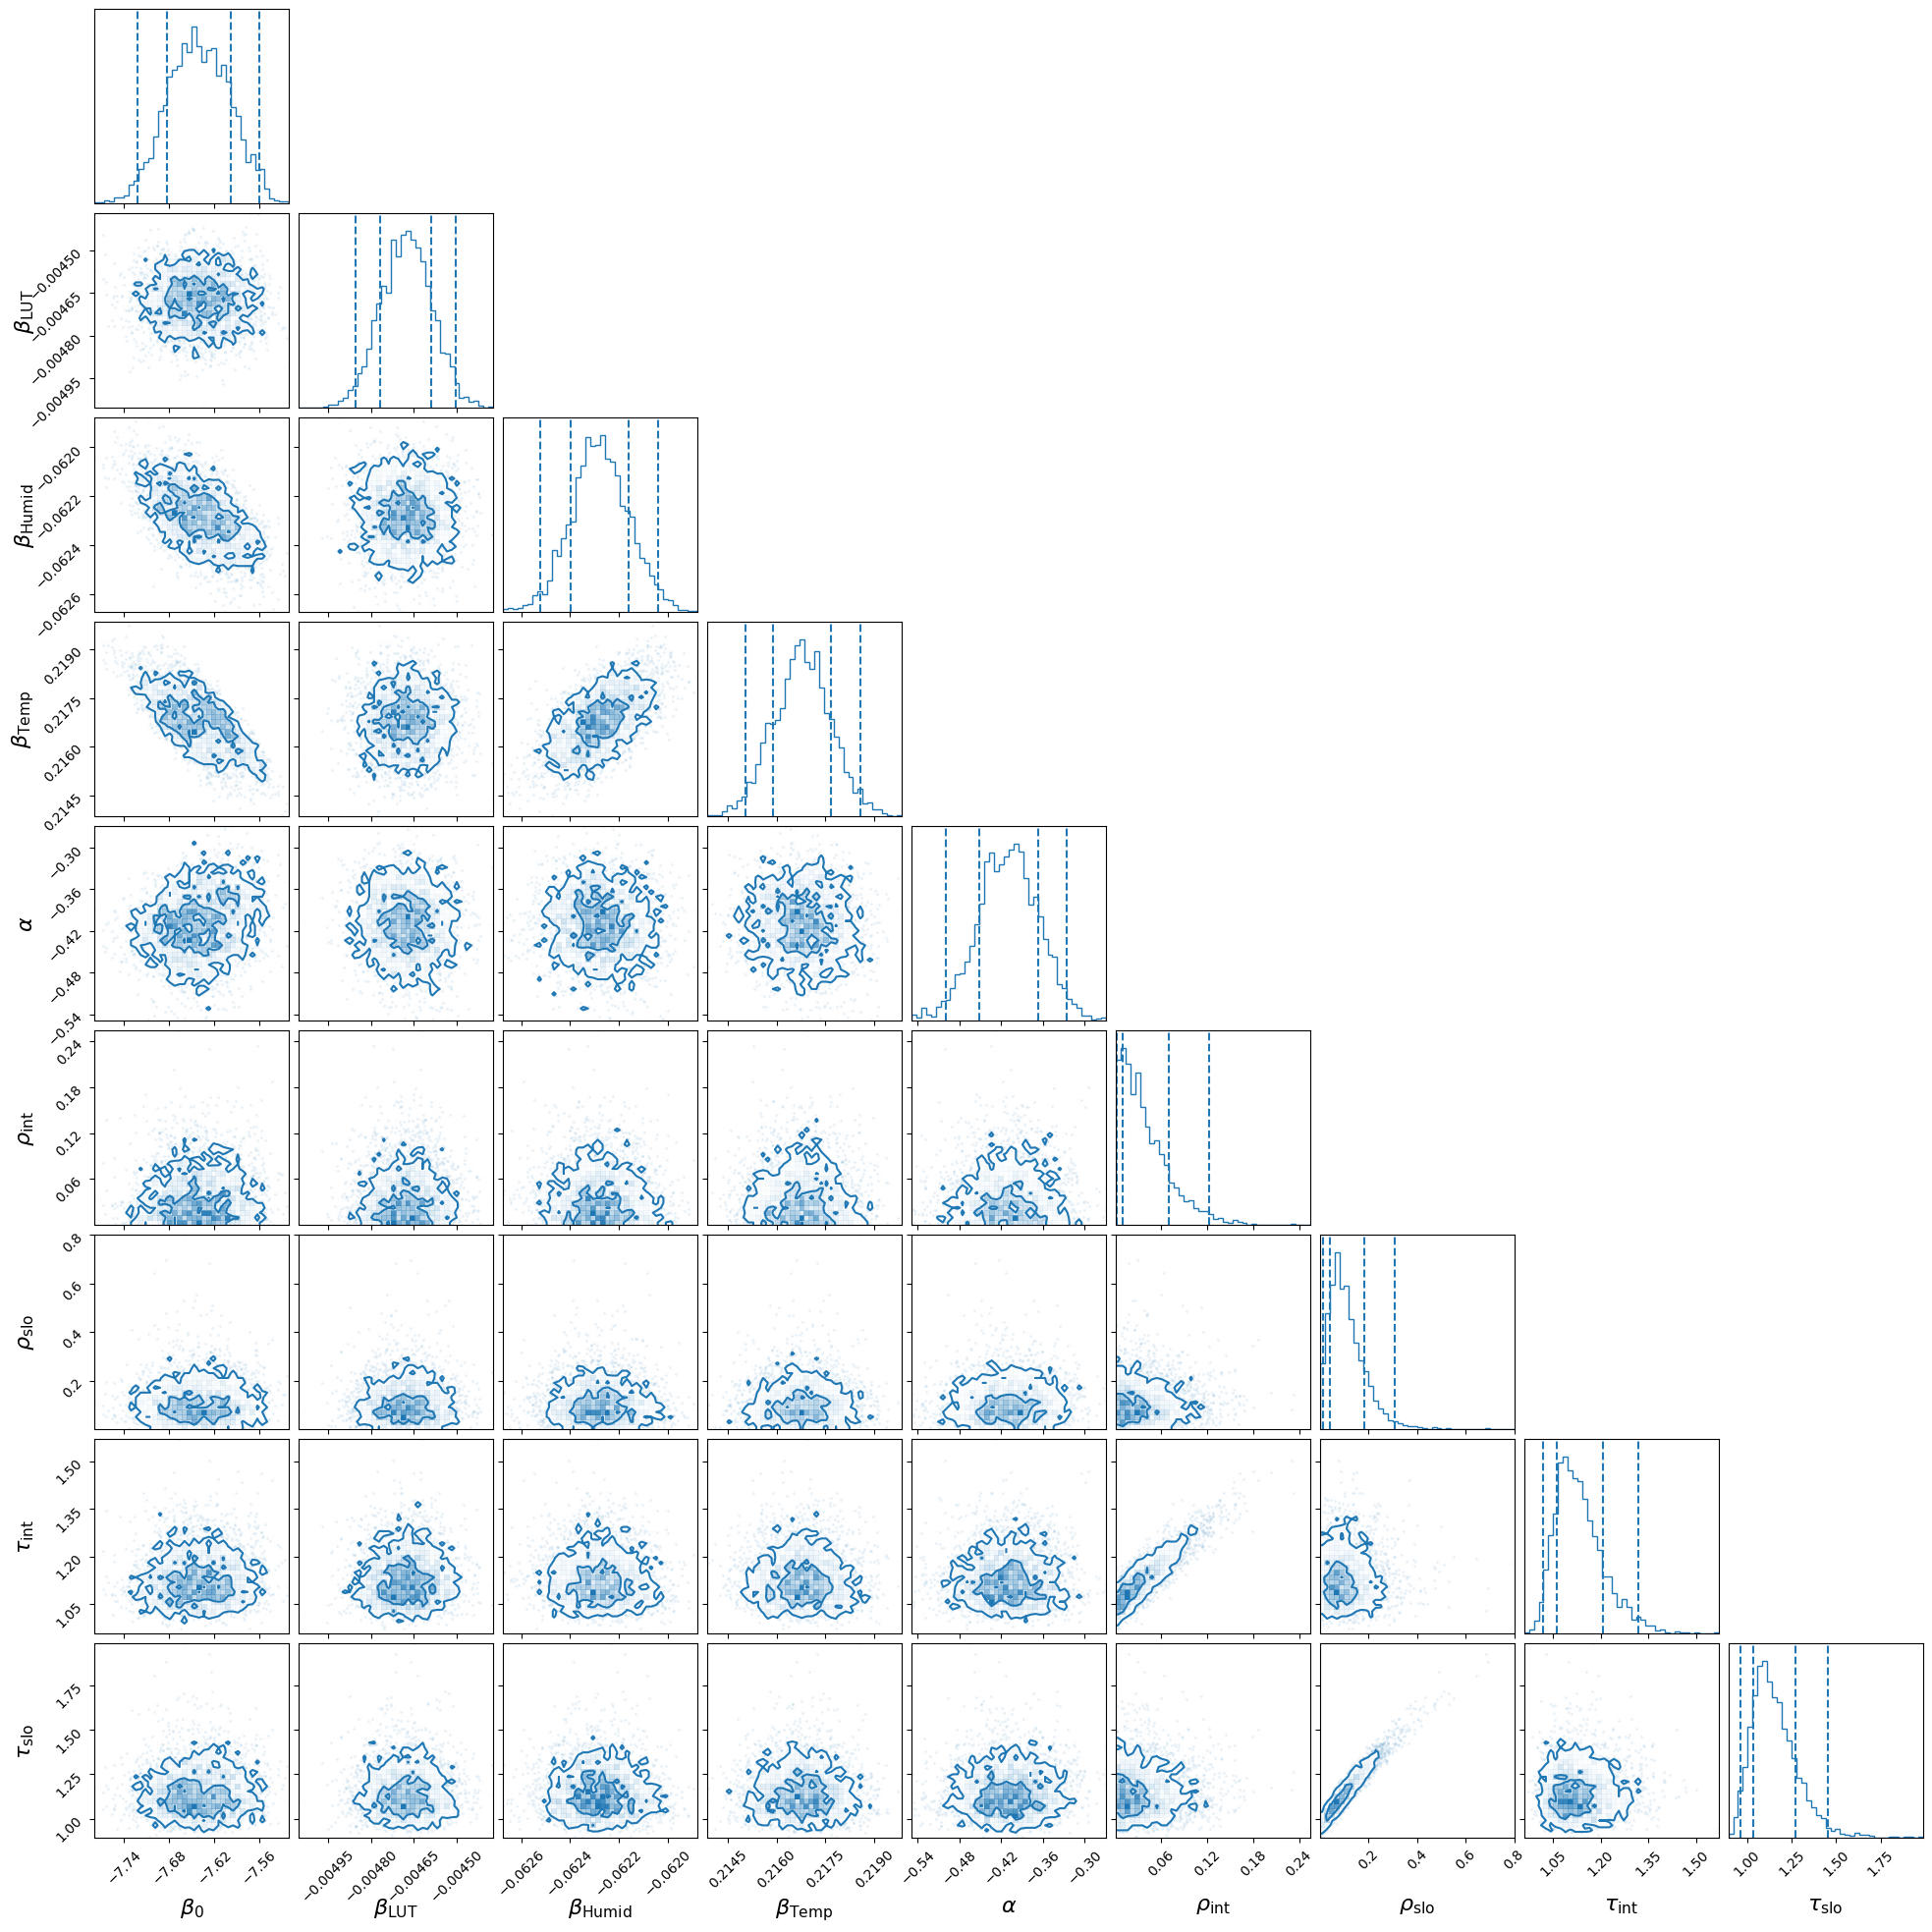

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Trim the last 1000 rows
data_trimmed = data.iloc[:-1000].copy()

# Corrected labels for the corner plot
labels_reduced = [
    r"$\beta_0$", r"$\beta_{\text{LUT}}$", r"$\beta_{\text{Humid}}$", r"$\beta_{\text{Temp}}$",
    r"$\alpha$", r"$\rho_{\text{int}}$", r"$\rho_{\text{slo}}$",
    r"$\tau_{\text{int}}$", r"$\tau_{\text{slo}}$"
]

# Create the corner plot
fig = plt.figure(figsize=(20, 20))
fig = corner.corner(
    data_trimmed.values, bins=40, labels=labels_reduced, color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig, label_kwargs={"fontsize": 16, "labelpad": 10000}
)

# Add a legend
fig.get_axes()[0].plot([], [], c="C0", )


# Save and display the plot
fig.savefig("img/corner_big_reduced.png", format="png")
plt.show()



In [11]:
# Load the CSV files for phi and delta
phi_file_path = 'csv/samples_big_phi11_01.csv'
delta_file_path = 'csv/samples_big_delta11_01.csv'

phi_data = pd.read_csv(phi_file_path, header=None)
delta_data = pd.read_csv(delta_file_path, header=None)

# Displaying basic info to understand structure
phi_data.head(), phi_data.shape, delta_data.head(), delta_data.shape


(        0         1         2         3         4         5         6    \
 0  1.420432  0.757338 -0.028682  2.139951  1.830121 -3.285330  0.471838   
 1  1.497169  0.852421 -0.038002  2.157790  1.883383 -2.968994  0.456441   
 2  1.399569  0.903121 -0.066990  2.132937  1.826503 -3.307464  0.470821   
 3  1.406628  0.893617 -0.076132  2.133249  1.818019 -3.301456  0.469701   
 4  1.386462  0.921402 -0.086836  2.136385  1.819266 -3.177547  0.488864   
 
         7         8         9    ...       548       549       550       551  \
 0 -1.500851  0.037797 -0.115345  ...  0.616539 -0.030382  1.000475 -0.126541   
 1 -1.513026  0.027061 -0.135326  ...  0.653213  0.057979  1.033955 -0.172207   
 2 -1.514305  0.083614 -0.121067  ...  0.616244 -0.046218  0.909279 -0.209560   
 3 -1.533731  0.062837 -0.121070  ...  0.618329 -0.048612  0.897348 -0.232827   
 4 -1.480374  0.094998 -0.121515  ...  0.576672 -0.075766  0.948038 -0.180282   
 
         552       553       554       555       556  

In [12]:
phi_file_path = 'csv/samples_big_phi11_01.csv'
delta_file_path = 'csv/samples_big_delta11_01.csv'
# Load the CSV file to examine its structure
file_path = 'csv/samples_big_no_phi_delta11_01.csv'




data = pd.read_csv(file_path)
Phi = pd.read_csv(phi_file_path, header=None).to_numpy()
Delta = pd.read_csv(delta_file_path, header=None).to_numpy()


# Flattened parameter arrays
Beta0 = data["beta0"].to_numpy()[:-1000]
Beta1 = data["beta_LUT"].to_numpy()[:-1000]
Beta2 = data["beta_Humid"].to_numpy()[:-1000]
Beta3 = data["beta_TEMP"].to_numpy()[:-1000]


# Additional parameters
Alpha = data["alpha"].to_numpy()[:-1000]
Rho_int = data["rho_int"].to_numpy()[:-1000]
Rho_slo = data["rho_slo"].to_numpy()[:-1000]
Tau_int = data["tau_int"].to_numpy()[:-1000]
Tau_slo = data["tau_slo"].to_numpy()[:-1000]




In [13]:
Phi_mean = np.mean(Phi, axis=0)

Delta_mean = np.mean(Delta, axis=0)

Beta0 =np.mean(Beta0,axis=0)
Beta1 =np.mean(Beta1,axis=0)
Beta2 =np.mean(Beta2,axis=0)
Beta3 =np.mean(Beta3,axis=0)
Alpha =np.mean(Alpha,axis=0)

In [15]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import libpysal

from geopandas import read_file

def get_biome_data(data):

    df = pd.read_csv(data, sep='\t')

    vec_LUT = df["vec_LUT"].to_numpy()
    vec_Prec = df["vec_Prec"].to_numpy()
    vec_Temp = df["vec_Temp"].to_numpy()
    vec_Humid = df["vec_Humid"].to_numpy()
    vec_Speed = df["vec_Speed"].to_numpy()
    vec_Area = df["vec_Area"].to_numpy()

    data = [vec_LUT, vec_Prec, vec_Temp, vec_Humid, vec_Speed, vec_Area]

    t = df["vec_Month"].to_numpy()

    munic = df["vec_Munic"].to_numpy()

    FS = df["vec_FS"].to_numpy()

    return [data, t, munic, FS]


def get_W(biome_W):
    return np.array( [np.array(biome_W.iloc[i,0].split(','), dtype='int')
                                   for i in range(0, biome_W.shape[0])])

Amazon_Rainforest = get_biome_data('Data/Data_Amazonia.txt')
Amazon_Rainforest_W = get_W(pd.read_csv('Data/W_Amazonia.csv', sep='\t'))

biome = Amazon_Rainforest
W = np.array(Amazon_Rainforest_W)


data = biome[0]
t = biome[1]
FS = biome[-1]

data_length = len(FS)
n_munic = np.size(W, 0)

LUT = data[0]
HUMID = data[3]
TEMP = data[2]
area = data[-1]

In [18]:
T_value = 120
Mu_new = np.exp(Beta0 + Beta1*LUT + Beta2*HUMID + Beta3*TEMP + 
                       np.concatenate([Phi_mean] * T_value) + (Alpha + np.concatenate([Delta_mean] * T_value))*(t-(T_value/2+0.5))/T_value)*area


In [19]:
file_path = 'csv/samples_samll_no_phi_delta14_33.csv'




data = pd.read_csv(file_path)
Phi = pd.read_csv(phi_file_path, header=None).to_numpy()
Delta = pd.read_csv(delta_file_path, header=None).to_numpy()


# Flattened parameter arrays
Beta0 = data["beta0"].to_numpy()
Beta1 = data["beta_LUT"].to_numpy()
Beta2 = data["beta_Humid"].to_numpy()
Beta3 = data["beta_TEMP"].to_numpy()


# Additional parameters
Alpha = data["alpha"].to_numpy()


Phi_mean = np.mean(Phi, axis=0)

Delta_mean = np.mean(Delta, axis=0)

Beta0 =np.mean(Beta0,axis=0)
Beta1 =np.mean(Beta1,axis=0)
Beta2 =np.mean(Beta2,axis=0)
Beta3 =np.mean(Beta3,axis=0)
Alpha =np.mean(Alpha,axis=0)

Mu_new_small = np.exp(Beta0 + Beta1*LUT + Beta2*HUMID + Beta3*TEMP  + (Alpha)*(t-(T_value/2+0.5))/T_value)*area

In [20]:
def give_avg_month_cal(Mu_new):

    Mu_avg_month_cal = np.zeros(12)

    for k in range(10):

        temp = np.zeros(12*n_munic)

        temp += Mu_new[k*n_munic*12: (k+1)*n_munic*12]

        for i in range(12):

            Mu_avg_month_cal[i] += sum(temp[i*n_munic:(i+1)*n_munic])/(n_munic*10)

    return Mu_avg_month_cal

Mu_avg_month_cal = give_avg_month_cal(Mu_new)
FS_avg_month_cal = give_avg_month_cal(FS)

In [21]:
def give_avg_month_cal(Mu_new):

    Mu_avg_month_cal = np.zeros(12)

    for k in range(10):

        temp = np.zeros(12*n_munic)

        temp += Mu_new[k*n_munic*12: (k+1)*n_munic*12]

        for i in range(12):

            Mu_avg_month_cal[i] += sum(temp[i*n_munic:(i+1)*n_munic])/(n_munic*10)

    return Mu_avg_month_cal

Mu_avg_month_cal_small = give_avg_month_cal(Mu_new_small)
FS_avg_month_cal = give_avg_month_cal(FS)

File not found at: csv/Data/Data_Amazonia.txt
Chi^2 Value: 55.909566141928615
P-value: 8.482587358935732e-11


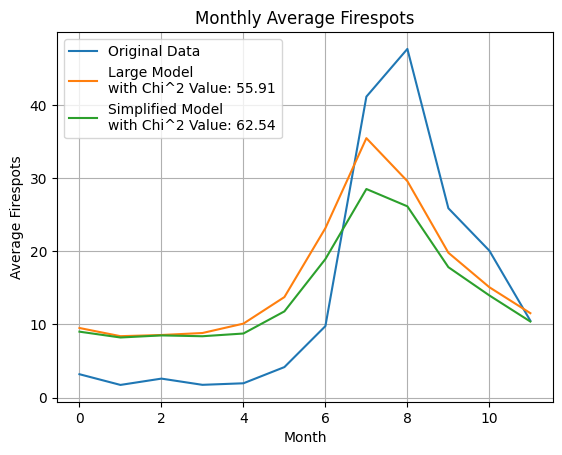

In [22]:
import scipy.stats as stats

def chi2_statistic(observed, expected):
    # Prevent division by zero by adding a small value
    return np.sum((observed - expected) ** 2 / (expected))


file_path = 'csv/Data/Data_Amazonia.txt'

try:
  df = pd.read_csv(file_path, sep='\t')  # Assuming tab-separated values
  print(df.head())  # Print the first few rows of the DataFrame
except FileNotFoundError:
  print(f"File not found at: {file_path}")
except pd.errors.ParserError:
  print(f"Error parsing the file at: {file_path}. Check the file format.")


# df_sorted_ = df.sort_values(by=["vec_Munic","vec_Month"])
# df_fitted_sorted = df_fitted.sort_values(by=["vec_Munic","vec_Month"])
# df_sorted_["vec_Month"] = np.tile(np.arange(1, 13), 5580)
# df_fitted_sorted["vec_Month"] = np.tile(np.arange(1, 13), 5580)
# monthly_mean_original_data = df_sorted_.groupby("vec_Month")["vec_FS"].mean()
# monthly_mean_fitted_data = df_fitted_sorted.groupby("vec_Month")["vec_FS"].mean()

# Calculate Chi-squared value as you've already done
observed_counts = FS_avg_month_cal
expected_counts = Mu_avg_month_cal
expected_counts_small = Mu_avg_month_cal_small

chi2_value = chi2_statistic(observed_counts, expected_counts)
print(f"Chi^2 Value: {chi2_value}")

chi2_value_small = chi2_statistic(observed_counts, expected_counts_small)

# Degrees of freedom (df) is the number of observations minus 1
df = len(observed_counts) - 7  # 12 months - 7 parameters (6 beta, 1 alpha)

# Calculate p-value using the Chi-squared distribution's survival function (1 - CDF)
p_value = stats.chi2.sf(chi2_value, df)
print(f"P-value: {p_value}")

# Plot the observed and fitted data
plt.plot(observed_counts, label="Original Data")
plt.plot(expected_counts, label="Large Model \nwith Chi^2 Value: {:.2f}".format(chi2_value))
plt.plot(expected_counts_small, label="Simplified Model \nwith Chi^2 Value: {:.2f}".format(chi2_value_small))


plt.xlabel("Month")
plt.ylabel("Average Firespots")
plt.title("Monthly Average Firespots")
plt.legend()
plt.grid(True)

plt.savefig("so_schön.png", format="png")
plt.show()

In [23]:
print(np.shape(Mu_new))

(66960,)


In [ ]:
T_value = 120

def give_Mu():

    Mu = np.zeros((len(Beta0), T_value*n_munic))

    for i in range(len(Mu)):

        Mu[i] = np.exp(Beta0[i] + Beta1[i]*LUT + Beta2[i]*HUMID + Beta3[i]*TEMP + 
                       np.concatenate([Phi[i]] * T_value) + (Alpha[i] + np.concatenate([Delta[i]] * T_value))*(t-(T_value/2+0.5))/T_value)*area

    return Mu


Mu = give_Mu()

def give_MU_month_tot():

    MU_month_tot = np.zeros((len(Beta0), T_value))

    for i in range(T_value):
        for k in range(len(Mu)):

            MU_month_tot[k][i] = sum(Mu[k][(i-1)*n_munic: i*n_munic])/n_munic

    return MU_month_tot


MU_month_tot = give_MU_month_tot()

In [ ]:
plt.figure()

bar_width = 0.35

x_pos = np.arange(len(labels))

x_pos_additional = x_pos + bar_width

bins = np.arange(0, 12)

hist_FS, edges = np.histogram(FS, bins=np.append(bins, np.inf))

normalized_hist_FS = hist_FS / len(FS)

hist_mu, edges = np.histogram(Mu, bins=np.append(bins, np.inf))

normalized_hist_mu = hist_mu / len(FS)

labels = [str(i) for i in range(11)] + ['>10']

plt.bar(x_pos, normalized_hist_FS, width=bar_width, color='skyblue', edgecolor='black')

plt.bar(x_pos_additional, normalized_hist_mu, width=bar_width, color='r', edgecolor='black', alpha=0.7)
# plt.set_title(biomenames[k].replace("", " "), fontsize=14)

plt.xticks(x_pos + bar_width / 2, labels)
plt.ylim(bottom=None, top=1)
plt.grid(True, axis='y')
plt.show()